# Exercise 04: RDKit and Molecular Docking

## Learning Objectives

In this exercise, you will learn to:
- Work with molecular representations (SMILES, SDF)
- Filter molecules using cheminformatics criteria
- Perform substructure searches
- **Debug and fix** buggy code
- Perform molecular docking with DockingPie

## Using AI Tools

You may use AI assistants (ChatGPT, Claude, etc.) for:
- Understanding RDKit syntax and functions
- Debugging code errors
- Generating code snippets

However, **you must demonstrate**:
- Your own understanding of molecular properties
- Critical evaluation of results
- Biological and chemical reasoning

**The exercises assess your understanding, not code generation.**

In [1]:
# Check if running on Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on Colab')
    !pip install rdkit pandas matplotlib

import warnings
warnings.filterwarnings('ignore')

Running on Colab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 31.1 MB/s eta 0:00:00


In [2]:
# Import libraries
from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import matplotlib.pyplot as plt

print("✓ All libraries loaded successfully")

✓ All libraries loaded successfully


## Introduction to RDKit

[RDKit](https://www.rdkit.org/) is a powerful open-source toolkit for cheminformatics. It allows you to:
- Read and write molecular structures in various formats (SMILES, SDF, MOL)
- Calculate molecular properties (MW, LogP, etc.)
- Perform substructure searches
- Filter molecular databases

### Basic Molecular Representations

**SMILES** (Simplified Molecular Input Line Entry System): A text representation of chemical structures.
- Example: `CCO` represents ethanol (CH₃CH₂OH)
- Example: `c1ccccc1` represents benzene

**SDF** (Structure-Data File): A file format that can store multiple molecules with their 3D coordinates and properties.

Molecular formula: C2H6O
Molecular weight: 46.07 g/mol


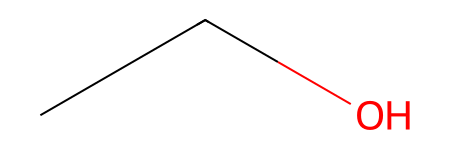

In [3]:
# Example: Creating a molecule from SMILES
mol = Chem.MolFromSmiles('CCO')  # Ethanol
print(f"Molecular formula: {Chem.rdMolDescriptors.CalcMolFormula(mol)}")
print(f"Molecular weight: {Descriptors.MolWt(mol):.2f} g/mol")

# Visualize the molecule
mol

Aspirin has benzene ring: True
Ethanol has benzene ring: False


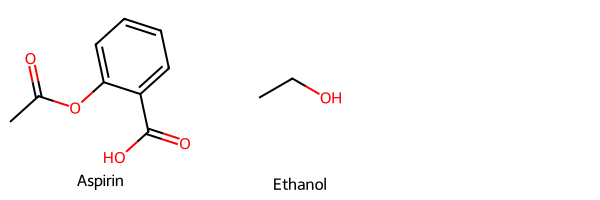

In [4]:
# Example: Substructure search - finding benzene rings
benzene = Chem.MolFromSmarts('c1ccccc1')  # SMARTS pattern for aromatic benzene

# Test molecules
aspirin = Chem.MolFromSmiles('CC(=O)Oc1ccccc1C(=O)O')
ethanol = Chem.MolFromSmiles('CCO')

print(f"Aspirin has benzene ring: {aspirin.HasSubstructMatch(benzene)}")
print(f"Ethanol has benzene ring: {ethanol.HasSubstructMatch(benzene)}")

# Visualize
Draw.MolsToGridImage([aspirin, ethanol], legends=['Aspirin', 'Ethanol'])

### Lipinski's Rule of Five

The **Rule of Five** is a set of criteria to evaluate drug-likeness:
1. Molecular weight ≤ 500 Da
2. LogP ≤ 5 (lipophilicity)
3. Hydrogen bond donors ≤ 5
4. Hydrogen bond acceptors ≤ 10

Molecules that meet these criteria are more likely to be orally bioavailable.

In [5]:
# Example: Checking Lipinski's Rule of Five
def check_lipinski(mol):
    """Check if a molecule passes Lipinski's Rule of Five."""
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)

    passes = (mw <= 500) and (logp <= 5) and (hbd <= 5) and (hba <= 10)

    return {
        'MW': mw,
        'LogP': logp,
        'HBD': hbd,
        'HBA': hba,
        'Passes_RO5': passes
    }

# Test with aspirin
aspirin = Chem.MolFromSmiles('CC(=O)Oc1ccccc1C(=O)O')
results = check_lipinski(aspirin)
print("Aspirin properties:")
for key, value in results.items():
    print(f"  {key}: {value}")

Aspirin properties:
  MW: 180.15899999999996
  LogP: 1.3101
  HBD: 1
  HBA: 3
  Passes_RO5: True


### Working with Molecular Databases

Now let's load a real database of drug molecules and analyze them.

Load the table of drugs (downloaded from [ChEMBL](https://www.ebi.ac.uk/chembl/) )

This table of drugs contains approximatelly ~15k drugs in different phases of clinical trials.
The information includes:
- Chembl ID
- Name
- Synonyms (associated with the drug)
- Phase (clinical trial phase)
- if Passes the Rule of Five (Ro5)
- and the structure in SMILES format

In [6]:
if 'google.colab' in str(get_ipython()):
  print('Running on colab')
  !wget https://raw.githubusercontent.com/yerkoescalona/structural_bioinformatics/main/ex04/chembl_drugs.txt.gz
else:
  print('Not running on colab.')
  print('You should have chembl_drugs.txt.gz in your path!')

Running on colab
--2025-12-04 09:52:41--  https://raw.githubusercontent.com/yerkoescalona/structural_bioinformatics/main/ex04/chembl_drugs.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1413458 (1.3M) [application/octet-stream]
Saving to: ‘chembl_drugs.txt.gz’

chembl_drugs.txt.gz 100%[===================>]   1.35M  --.-KB/s    in 0.05s   

2025-12-04 09:52:41 (25.0 MB/s) - ‘chembl_drugs.txt.gz’ saved [1413458/1413458]



In [7]:
# Load the ChEMBL drugs database
df = pd.read_csv('chembl_drugs.txt.gz', sep=';')

print(f"Loaded {len(df)} drug entries")
print(f"\nColumn names: {list(df.columns[:10])}...")  # Show first 10 columns
print(f"\nFirst few rows:")
df.head()

Loaded 14805 drug entries

Column names: ['Parent Molecule', 'Name', 'Synonyms', 'Research Codes', 'Phase', 'Drug Applicants', 'USAN Stem', 'USAN Year', 'USAN Definition', 'USAN Stem - Substem']...

First few rows:


,Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,...,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
0,CHEMBL492491,FENVALERATE,BELMARK|FENVALERATE|PHENVALERATE|PYDRIN|S-5602...,S-5602|SD-43775|WL-43775,-1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,Racemic Mixture,0,0,0,0,0,Unknown,CC(C)C(C(=O)OC(C#N)c1cccc(Oc2ccccc2)c1)c1ccc(C...
1,CHEMBL2103777,THIOPHANATE,NSC-170810|THIOPHANATE,NSC-170810,-1.0,NaN,NaN,NaN,NaN,NaN,...,1,0,Achiral Molecule,0,0,0,0,0,Unknown,CCOC(=O)NC(=S)Nc1ccccc1NC(=S)NC(=O)OCC
2,CHEMBL1868702,GESTRINONE,A 46 745|A-46-745|A-46745|DIMETRIOSE|GESTRINON...,A 46 745|A-46-745|A-46745|R 2323|R-2323|RU 232...,4.0,NaN,'-estr-; -rinone',1978.0,estrogens; cardiotonics (amrinone type),'-estr-(-estr-); -rinone(-rinone)',...,1,0,Single Stereoisomer,0,0,0,0,0,Unknown,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3C=...
3,CHEMBL2104213,DESMENINOL,DESMENINOL|METHIONINE HYDROXY ANALOG,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,1,0,Racemic Mixture,0,0,0,0,0,Unknown,CSCCC(O)C(=O)O
4,CHEMBL1904952,QUAZODINE,MJ 1988|MJ-1988|QUAZODINE,MJ 1988|MJ-1988,-1.0,NaN,NaN,1968.0,NaN,NaN,...,1,0,Achiral Molecule,0,0,0,0,0,Unknown,CCc1ncnc2cc(OC)c(OC)cc12


In [8]:
# Convert SMILES strings to RDKit molecule objects
# This conversion is NECESSARY because:
# 1. SMILES are just text strings - we need molecule objects to perform operations
# 2. RDKit molecule objects enable:
#    - Substructure searching (e.g., finding molecules with benzene rings)
#    - Property calculations (MW, LogP, HBD, HBA, etc.)
#    - Molecular visualization and drawing
#    - 3D coordinate generation for docking
# 3. Without conversion, we can only work with text - no chemical operations possible

print(f"Original dataset: {len(df)} entries")
print(f"Missing SMILES: {df['Smiles'].isna().sum()}")

# Create molecule objects from SMILES strings
# Note: Invalid/missing SMILES will result in None values
# We need to handle NaN values by converting them to None first
df['Molecule'] = df['Smiles'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)

# Check conversion results
valid_mols = df['Molecule'].notna().sum()
print(f"\nSuccessfully created {valid_mols} RDKit molecule objects")
print(f"Invalid/missing: {len(df) - valid_mols}")
print("\n✓ Now we can perform substructure searches, calculate properties, and visualize molecules!")

# Show sample with molecule objects
df[['Parent Molecule', 'Name', 'Phase', 'Passes Rule of Five', 'Molecule']].head()

Original dataset: 14805 entries
Missing SMILES: 3915


[09:53:27] WARNING: not removing hydrogen atom without neighbors
[09:53:27] WARNING: not removing hydrogen atom without neighbors
[09:53:27] WARNING: not removing hydrogen atom without neighbors
[09:53:28] WARNING: not removing hydrogen atom without neighbors
[09:53:28] WARNING: not removing hydrogen atom without neighbors
[09:53:28] WARNING: not removing hydrogen atom without neighbors
[09:53:28] WARNING: not removing hydrogen atom without neighbors



Successfully created 10890 RDKit molecule objects
Invalid/missing: 3915

✓ Now we can perform substructure searches, calculate properties, and visualize molecules!


,Parent Molecule,Name,Phase,Passes Rule of Five,Molecule
0,CHEMBL492491,FENVALERATE,-1.0,0,<rdkit.Chem.rdchem.Mol object at 0x7d777279c3c0>
1,CHEMBL2103777,THIOPHANATE,-1.0,1,<rdkit.Chem.rdchem.Mol object at 0x7d773a273a70>
2,CHEMBL1868702,GESTRINONE,4.0,1,<rdkit.Chem.rdchem.Mol object at 0x7d773a273840>
3,CHEMBL2104213,DESMENINOL,-1.0,1,<rdkit.Chem.rdchem.Mol object at 0x7d773a2738b0>
4,CHEMBL1904952,QUAZODINE,-1.0,1,<rdkit.Chem.rdchem.Mol object at 0x7d773a273b50>


In [9]:
# Example: Using Pandas + RDKit to find molecules with benzene rings
# Define the benzene pattern (aromatic 6-membered ring)
benzene_pattern = Chem.MolFromSmarts('c1ccccc1')

# Create a new column using Pandas apply() + RDKit substructure search
# Check each molecule for benzene ring (handle None values)
df['has_benzene'] = df['Molecule'].apply(
    lambda mol: mol.HasSubstructMatch(benzene_pattern) if mol is not None else False
)

# Count molecules with and without benzene rings
n_with_benzene = df['has_benzene'].sum()
n_without_benzene = (~df['has_benzene']).sum()

print(f"Molecules WITH benzene rings: {n_with_benzene}")
print(f"Molecules WITHOUT benzene rings: {n_without_benzene}")
print(f"Percentage with benzene: {n_with_benzene / len(df) * 100:.1f}%")

# Filter the dataframe to show only molecules with benzene
benzene_drugs = df[df['has_benzene']].copy()

print(f"\nSample of drugs containing benzene rings:")
benzene_drugs[['Name', 'Phase', 'Passes Rule of Five']].head(10)

Molecules WITH benzene rings: 7652
Molecules WITHOUT benzene rings: 7153
Percentage with benzene: 51.7%

Sample of drugs containing benzene rings:


,Name,Phase,Passes Rule of Five
0,FENVALERATE,-1.0,0
1,THIOPHANATE,-1.0,1
4,QUAZODINE,-1.0,1
5,NICTINDOLE,-1.0,1
7,METHOXYPHEDRINE,-1.0,1
8,FENCLONINE,-1.0,1
11,ANETHOLTRITHION,-1.0,1
13,CARZENIDE,-1.0,1
15,NAMIROTENE,-1.0,0
16,BUQUITERINE,-1.0,1


---

# Exercise 1: Debug the Buggy Code

## Background

A colleague wrote code to filter the drug database and save approved drugs that:
1. **Pass** the Rule of Five (drug-like properties)
2. Are in **Phase 3 or Phase 4** clinical trials (advanced stages)
3. Contain a **naphtalene** substructure

The filtered results should be saved as an SDF file.

However, **the code has multiple bugs and doesn't work correctly**.

## The Buggy Code

In [ ]:
def filter_and_save_drugs(filepath, output_file) -> pd.DataFrame:
    """
    Filter drugs that pass Rule of Five, are in Phase 3+, and contain naphthalene.
    Save results to SDF file.

    Args:
        filepath (str): Path to the input CSV file.
        output_file (str): Path to the output SDF file.

    Returns:
        pd.DataFrame: Filtered dataframe of approved drugs.
    """
    dataframe = pd.read_csv(filepath, sep=';')

    print(f"Starting with {len(dataframe)} molecules")

    # Clean the data before converting to molecules
    dataframe = dataframe[dataframe['Smiles'].notna()]
    dataframe['Smiles'] = dataframe['Smiles'].astype(str)

    print(f"After cleaning: {len(dataframe)} molecules")

    PandasTools.AddMoleculeColumnToFrame(dataframe, smilesCol='Smiles', molCol='Molecule')

    # Filter: Passes Rule of Five
    filtered = dataframe[dataframe['Passes Rule of Five'] == 'Yes']
    print(f"After Rule of Five filter: {len(filtered)} molecules")

    # Filter: Phase 3 or higher
    filtered = filtered[filtered['Phase'] > 3]
    print(f"After Phase filter: {len(filtered)} molecules")

    # Filter: Contains naphthalene substructure
    naphthalene_pattern = Chem.MolFromSmarts('c1ccccc1')
    naphthalene_matches = []

    for mol in filtered['Molecule']:
        if mol is not None and mol.HasSubstructMatch(naphthalene_pattern):
            naphthalene_matches.append(True)
        else:
            naphthalene_matches.append(False)

    filtered['has_naphthalene'] = naphthalene_matches
    final_df = filtered[filtered['has_naphthalene'] == True]

    print(f"After naphthalene filter: {len(final_df)} molecules")

    final_df = final_df[final_df['Molecule'].notna()]

    PandasTools.WriteSDF(final_df, output_file, molColName='Molecule', properties=list(final_df.columns))
    print(f"✓ Saved {len(final_df)} molecules to {output_file}")

    return final_df

result = filter_and_save_drugs('chembl_drugs.txt.gz', 'approved_drugs_buggy.sdf')

## Your Tasks

### Task 1.1: Identify the Bugs

Find **3 bugs** in the code above. For each bug, explain:
- Where it is located (line/section)
- What is wrong
- Why it's incorrect
- What impact it has on the results
- What the correct version should be

**Write your answers in the markdown cell below.**

### Task 1.1: Bugs Found

**Bug #1:**
- Location: naphthalene_pattern = Chem.MolFromSmarts('c1ccccc1')
- What's wrong: The pattern “c1ccccc1” describes benzene, not naphthalene.
- Why incorrect: The task states that only molecules containing a naphthalene substructure should be retained.
- Impact: Molecules with only a single benzene ring (or other aromatic systems) are incorrectly included.
- Correct version: naphthalene_pattern = Chem.MolFromSmarts('c1cccc2c1cccc2')

**Bug #2:**
- Location: filtered = filtered[filtered['Phase'] > 3]
- What's wrong: The condition uses > 3, that means strictly greater than 3. This means that only entries with phase == 4 are retained.
- Why incorrect: The task wants that Phase 3 and 4 are retained.
- Impact: All active ingredients that are ‘only’ in phase 3 are removed from the data set. The output therefore only contains phase 4 drugs.
- Correct version: filtered = filtered[filtered['Phase'] >= 3]

**Bug #3:**
- Location: dataframe = pd.read_csv(filepath, sep=';')
- What's wrong: The separator is set to “;”.
- Why incorrect: With sep=“;”, the file is read incorrectly
- Impact: the column names cannot be found. No valid output is generated.
- Correct version: dataframe = pd.read_csv(filepath, sep='\t')

**Additional bugs or improvements (if any):**
-

### Task 1.2: Fix the Code

Write a corrected version of the function with:
- All bugs fixed
- Proper error handling (e.g., checking for None molecules)
- Clear comments explaining key steps
- Informative print statements showing progress

In [18]:
# Task 1.2: Your fixed version here

def filter_and_save_drugs(filepath, output_file) -> pd.DataFrame:
    """
    Filter drugs that pass Rule of Five, are in Phase 3+, and contain naphthalene.
    Save results to SDF file.

    Args:
        filepath (str): Path to the input CSV file.
        output_file (str): Path to the output SDF file.

    Returns:
        pd.DataFrame: Filtered dataframe of approved drugs.
    """
    # YOUR CODE HERE
    dataframe = pd.read_csv(filepath, sep=';')

    print(f"Starting with {len(dataframe)} molecules")

    # Clean the data before converting to molecules
    dataframe = dataframe[dataframe['Smiles'].notna()]
    dataframe['Smiles'] = dataframe['Smiles'].astype(str)
    print(f"After cleaning: {len(dataframe)} molecules")

    PandasTools.AddMoleculeColumnToFrame(dataframe, smilesCol='Smiles', molCol='Molecule')

    # ---------- Rule of Five filter (robuster) ----------
    col = dataframe['Passes Rule of Five']

    # Falls die Spalte bool-Values enthält (True/False)
    if col.dtype == bool:
        rule5_mask = col
    else:
        # Strings vereinheitlichen (Whitespace + Groß/Kleinschreibung)
        rule5_mask = col.astype(str).str.strip().str.upper() == 1

    filtered = dataframe[rule5_mask]
    print(f"After Rule of Five filter: {len(filtered)} molecules")

    # ---------- Phase 3 oder 4 ----------
    filtered = filtered[filtered['Phase'] >= 3]
    print(f"After Phase filter: {len(filtered)} molecules")

    # ---------- Naphthalin-Substruktur ----------
    naphthalene_pattern = Chem.MolFromSmarts('c1cccc2c1cccc2')
    naphthalene_matches = []

    for mol in filtered['Molecule']:
        if mol is not None and mol.HasSubstructMatch(naphthalene_pattern):
            naphthalene_matches.append(True)
        else:
            naphthalene_matches.append(False)

    filtered['has_naphthalene'] = naphthalene_matches
    final_df = filtered[filtered['has_naphthalene'] == True]
    print(f"After naphthalene filter: {len(final_df)} molecules")

    final_df = final_df[final_df['Molecule'].notna()]

    PandasTools.WriteSDF(final_df, output_file,
                         molColName='Molecule',
                         properties=list(final_df.columns))
    print(f"Saved {len(final_df)} molecules to {output_file}")

    return final_df

### Task 1.3: Test Your Fixed Code

Run your fixed function and verify it works correctly.

In [19]:
# Test your fixed function
result = filter_and_save_drugs('chembl_drugs.txt.gz', 'approved_drugs_fixed.sdf')

Starting with 14805 molecules
After cleaning: 10890 molecules


[11:44:39] WARNING: not removing hydrogen atom without neighbors
[11:44:39] WARNING: not removing hydrogen atom without neighbors
[11:44:39] WARNING: not removing hydrogen atom without neighbors
[11:44:40] WARNING: not removing hydrogen atom without neighbors
[11:44:40] WARNING: not removing hydrogen atom without neighbors
[11:44:40] WARNING: not removing hydrogen atom without neighbors
[11:44:40] WARNING: not removing hydrogen atom without neighbors


After Rule of Five filter: 0 molecules
After Phase filter: 0 molecules
After naphthalene filter: 0 molecules
Saved 0 molecules to approved_drugs_fixed.sdf


In [17]:
import pandas as pd

df = pd.read_csv('chembl_drugs.txt.gz', sep=';')
print(df['Passes Rule of Five'].unique())

[0 1]


---

# Molecular Docking with DockingPie

Now we'll move to the practical docking exercise using PyMOL and DockingPie.

## Step 0: Install PyMOL

Follow the instruction to download and install PyMOL from moodle




## Step 1: Installing DockingPie and Dependencies

### First, install DockingPie and its required dependencies.

- Download the dockingpie plugin from the [GitHub repository](https://github.com/paiardin/DockingPie). Specifically the following zip file: [DockingPie.zip](https://github.com/paiardin/DockingPie/archive/refs/heads/main.zip)

- Launch PyMOL.
- Navigate to Plugin → Plugin Manager from the main menu to open the plugin manager window.
- Click on Install New Plugin, then click the Choose File... button. Select the DockingPie ZIP file you downloaded.



![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/01_still_dockingpie.png?raw=1)

### Configure and Install Dependencies

DockingPie requires external tools like AutoDock Vina. Install them as follows.

- Go to Plugin → DockingPie → CONFIGURATION tab and click on "Configure". This procedure will allow you to install the necessary dependencies.
- Install Vina by clicking on the "Install Vina" button.


![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/02_configure_install_dockingpie_dependencies.png?raw=1)

AutoDock Vina is used for the docking calculations.

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/03_install_vina.png?raw=1)

## Step 2: Preparing the Protein Structure

A clean and correctly prepared protein structure is essential for accurate docking results.
We will fetch the protein structure with PDB ID 1FSZ from the Protein Data Bank (PDB). This protein is used as an example; you can replace it with any protein of your interest.

In PyMOL, run the following command:

```python
fetch 1fsz
```

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/04_fetch_pdb.png?raw=1)


### Step 3: Create a Protein Object.

To prepare the protein for docking, we need to isolate the protein from other molecules like ligands, water, and ions.

Create a protein object for docking.
If you are dealing with a unique protein, it is necessary to create a protein object for the docking process.
Start with a selection and then with the protein object.


In PyMOL, execute the following commands:

```python
select protein, not hetatm
create 1fsz_protein, protein
```

For this case:
- `select protein, not hetatm`: This selects all atoms that are not labeled as HETATM (heteroatoms like ligands, ions, and solvent molecules).
- `create 1fsz_protein, protein`: This creates a new object named 1fsz_protein containing only the protein atoms.


![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/05_create_protein_object.png?raw=1)



## Step 4: Preparing the Ligand Molecule

Next, we need to extract the ligand from the protein structure or prepare it separately.

In this example, the ligand has a residue name of GDP (Guanosine diphosphate).

Run the following commands in PyMOL:

```python
select ligand, resname GDP
create 1fsz_ligand, ligand
```

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/06_create_ligand_object.png?raw=1)


## Step 5: Setting Up the Docking Environment

We go to the DockingPie interface to set up the docking environment.

### Set the Protein in the Docking Session

To set the protein in the docking session, click on the "Vina" tab and then on the "Receptors" tab.
Then click on "Import from PyMOL" to import the protein object.

Select the protein object from the "Receptors settings" panel, and choose the proper settings, like adding hydrogens, remove water, and other options.

Click on "Generate receptor" and then select the protein object created and click on "Set".

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/07_set_protein.png?raw=1)

### Set the Ligand in the Docking Session

Similarly, set the ligand in the docking session.

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/08_set_ligand.png?raw=1)

## Step 6: Define the Docking Grid

Defining the docking grid is a crucial step that determines the search space for the docking algorithm. This corresponds to the region where the ligand will be docked into the protein.

You can use PyMOL to determine the center of the binding site or use the coordinates of the co-crystallized ligand ("Calculate Grid by selection").

Important values to set:

- Grid dimensions: You can set the grid dimensions in the x, y, and z directions, based on size of the the grid spacing (in Å).

- Grid center: You can set the grid center based on the coordinates of the binding site.

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/09_set_grid.png?raw=1)

Ensure the grid box covers the active site.

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/10_visualize_grid.png?raw=1)

### Step 7: Running the Docking Simulation

Start the docking process.

Important values to set:

- Poses: The number of binding modes to generate.
- Exhaustiveness: Controls the thoroughness of the search (higher values increase computation time).
- Energy Range: The maximum energy difference between the best binding mode and the worst one.

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/11_run_docking.png?raw=1)

### Step 8: Analyzing the Results

After the docking simulation is complete, it's essential to analyze the results to understand the ligand's binding modes and interactions.

Important results to retrieve:

- Pose ID: An identifier for each docking pose.
- Affinity (kcal/mol): The binding energy of the ligand to the protein. Lower (more negative) scores indicate stronger predicted binding affinities.
- RMSD: The root mean square deviation of the ligand poses, related to the first pose.


## Step 9: Retrieve and Observe the Docking Results

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/12_retrieve_results.png?raw=1)

Observe the Ligand Configurations

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/13_observe_ligand_configurations.png?raw=1)

Use [PLIP](https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index) (Protein-Ligand Interaction Profiler) to analyze and visualize detailed interactions between the protein and ligand.

![](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex04/images/14_docking_results_PLIP.png?raw=1)







![]()

# Docking Exercises:

1. Describe all the interactions between the ligand and the protein.
2. Use another ligand GTP. What are the differences in the interactions between the ligand and the protein?
3. Using those difference, could you be able to predict the conformational change of the protein when binding to GDP or GTP?

# For the Project

If your proteins can potentially interact with a ligand you can use the following workflow:
1. Find the Smiles format of the ligand in the ChEMBL database.
2. Use your PDB id and ligand Smiles format for the docking.
3. Describe the interactions between the ligand and the protein.

If your protein doesn't have a ligand, you can use the following workflow:
1. Use one of the following molecules as a ligand to your protein:

- Formaldehyde or Acetaldehyde: These small aldehyde molecules can be used to show how different functional groups (like the aldehyde group) interact with proteins. They can illustrate polar interactions and the role of hydrogen bonding in docking.

- Glycerol: This molecule, with its three hydroxyl groups, can demonstrate polyol interactions with proteins. It's particularly relevant for showing hydrogen bonding and the effect of multiple binding sites.

- Acetic Acid or Propionic Acid: These small carboxylic acids can be used to discuss the importance of charge in protein-ligand interactions, showing how deprotonation and protonation states affect docking.

- Benzene or Toluene: These aromatic compounds can illustrate hydrophobic interactions and pi-stacking, which are important in the docking of many drugs and natural ligands.

- Nitrate or Phosphate Ions: As small inorganic ions, they can be used to teach about ionic interactions and the role of electrostatics in protein-ligand docking.

- Urea or Thiourea: These molecules can be used to show how amide and thiol groups interact with proteins, and they're particularly interesting for discussing solvation effects and hydrogen bonding.

2. Use your PDB id and ligand Smiles format for the docking.
3. Describe the interactions between the ligand and the protein.
